In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [95]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [96]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

## Simple network

In [17]:
df = df_full.drop(columns=['dist_to_station', 'degree']+weather_var, inplace = False)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,43,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,6.805269,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,57,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,48,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,23,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [19]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18273


In [20]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.153830 , Valid Loss 18.293400 ,Train R2 0.147191, Valid R2 0.143538
Epoch 11: Train Loss 18.148833 , Valid Loss 17.855066 ,Train R2 0.171249, Valid R2 0.164060
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 18.009713 , Valid Loss 17.821789 ,Train R2 0.174375, Valid R2 0.165618
Epoch 31: Train Loss 17.961899 , Valid Loss 17.774869 ,Train R2 0.177440, Valid R2 0.167814
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 40: Train Loss 17.915306 , Valid Loss 17.767649 , Train R2 0.178753, Valid R2 0.168152


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

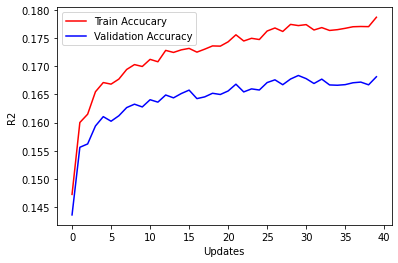

In [21]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

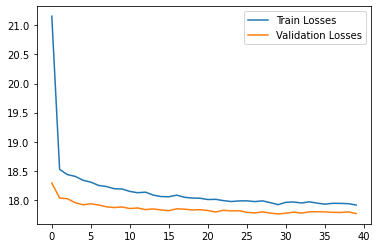

0.1733801984428197


In [22]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

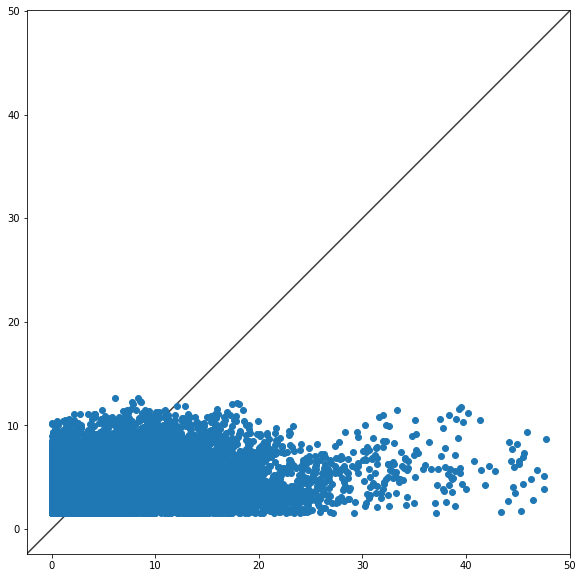

In [23]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No Zones

In [24]:
df = df_full.iloc[:,:8]
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1
0,43,12.529378,0,6.805269,0,0,1,0
1,86,14.027280,0,6.805269,0,0,1,0
2,5,17.751882,0,6.805269,1,0,0,0
3,30,1.806991,0,6.805269,0,0,1,0
4,32,13.214864,0,6.805269,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0
326588,57,14.221806,0,6.457874,1,0,0,0
326589,48,16.451925,0,6.457874,1,0,0,0
326590,23,15.140361,0,6.457874,0,0,1,0


In [25]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [26]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.0),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.0),
            nn.Linear(128,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
) 35329


In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.061210 , Valid Loss 19.008892 ,Train R2 0.092832, Valid R2 0.096719
Epoch 11: Train Loss 19.251990 , Valid Loss 18.919582 ,Train R2 0.097029, Valid R2 0.100963
Epoch 21: Train Loss 19.229286 , Valid Loss 18.899172 ,Train R2 0.098355, Valid R2 0.101933
Epoch 31: Train Loss 19.213632 , Valid Loss 18.883328 ,Train R2 0.099163, Valid R2 0.102686
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 19.203977 , Valid Loss 18.880782 ,Train R2 0.099399, Valid R2 0.102807
Epoch 51: Train Loss 19.198334 , Valid Loss 18.879052 ,Train R2 0.099693, Valid R2 0.102889
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 58: Train Loss 19.205669 , Valid Loss 18.884600 , Train R2 0.099339, Valid R2 0.102625


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

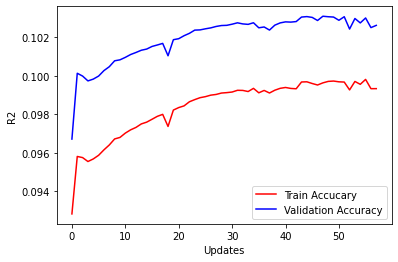

In [28]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

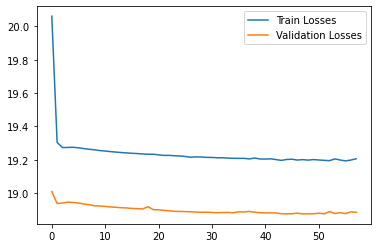

0.09767658829297654


In [29]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

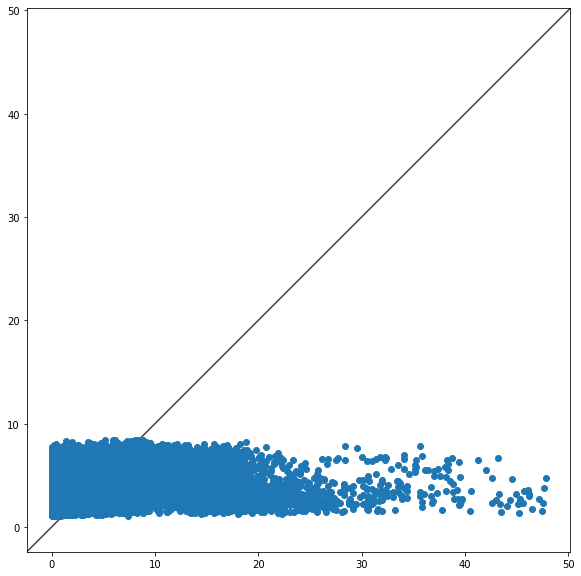

In [30]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With embedding

In [31]:
df = df_full.drop(columns=['dist_to_station', 'degree']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,43,0,6.805269,0,0,1,0,209
1,86,0,6.805269,0,0,1,0,138
2,5,0,6.805269,1,0,0,0,56
3,30,0,6.805269,0,0,1,0,235
4,32,0,6.805269,0,1,0,0,75
...,...,...,...,...,...,...,...,...
326587,94,0,6.457874,0,0,1,0,63
326588,57,0,6.457874,1,0,0,0,45
326589,48,0,6.457874,1,0,0,0,75
326590,23,0,6.457874,0,0,1,0,148


In [32]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [33]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(7+emb_dim,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 3)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 3)
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 44816


In [34]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.514916 , Valid Loss 19.149944 ,Train R2 0.109602, Valid R2 0.110563
Epoch 11: Train Loss 17.738876 , Valid Loss 17.967264 ,Train R2 0.178262, Valid R2 0.165494
Epoch 21: Train Loss 17.555576 , Valid Loss 17.886806 ,Train R2 0.184790, Valid R2 0.169231
Epoch 31: Train Loss 17.436147 , Valid Loss 17.839462 ,Train R2 0.190329, Valid R2 0.171430
Epoch 41: Train Loss 17.357896 , Valid Loss 17.829721 ,Train R2 0.194286, Valid R2 0.171882
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 17.312125 , Valid Loss 17.834221 ,Train R2 0.198153, Valid R2 0.171673
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 53: Train Loss 17.290276 , Valid Loss 17.834862 , Train R2 0.196823, Valid R2 0.171643


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

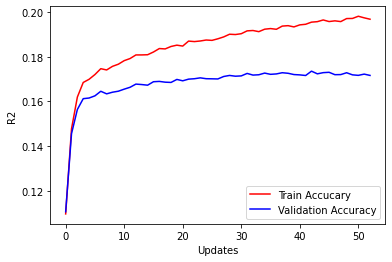

In [35]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

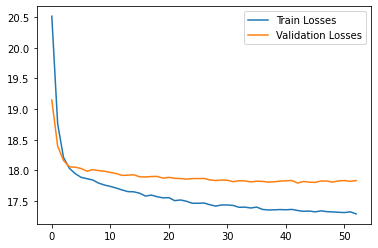

0.17552346110406747


In [36]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

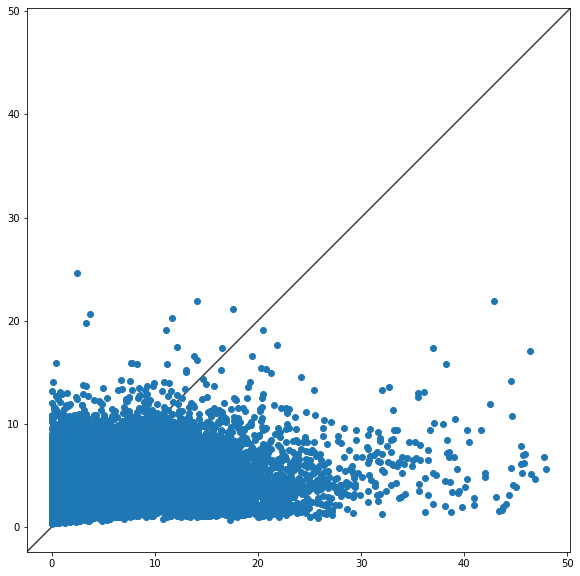

In [37]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With degree

In [38]:
df = df_full.drop(columns=['dist_to_station']+weather_var, inplace = False)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [40]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            #nn.Linear(64,64),
            #nn.ReLU(),#nn.BatchNorm1d(128)),
            #nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 42881


In [41]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.105185 , Valid Loss 17.536041 ,Train R2 0.187411, Valid R2 0.180887
Epoch 11: Train Loss 16.845671 , Valid Loss 17.105976 ,Train R2 0.222964, Valid R2 0.200975
Epoch 21: Train Loss 16.642997 , Valid Loss 17.018119 ,Train R2 0.233562, Valid R2 0.205079
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 29: Train Loss 16.542717 , Valid Loss 16.981734 , Train R2 0.242336, Valid R2 0.206779


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

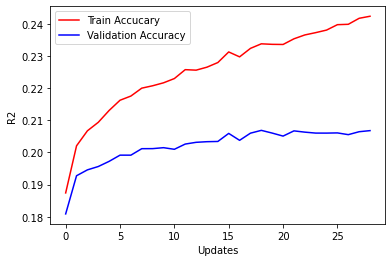

In [42]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

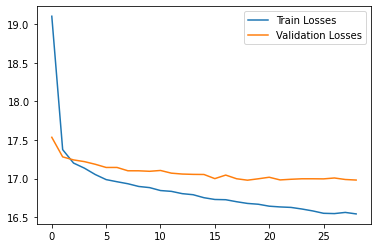

0.21419181614087812


In [43]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

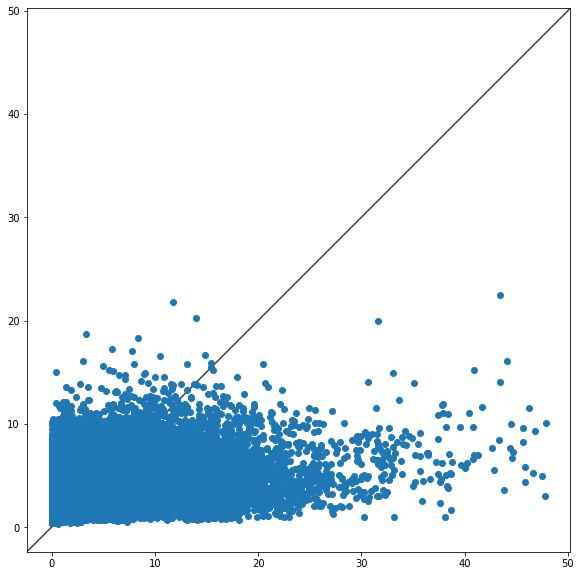

In [44]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [45]:
df = df_full.drop(columns=weather_var+['degree'], inplace = False)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,43,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,5,0,6.805269,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,57,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [46]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [47]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 25665


In [48]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.301349 , Valid Loss 18.270632 ,Train R2 0.156741, Valid R2 0.147045
Epoch 11: Train Loss 17.499285 , Valid Loss 17.865703 ,Train R2 0.195804, Valid R2 0.165949
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 17.303845 , Valid Loss 17.839077 ,Train R2 0.206647, Valid R2 0.167192
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 23: Train Loss 17.281183 , Valid Loss 17.846272 , Train R2 0.206202, Valid R2 0.166856


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

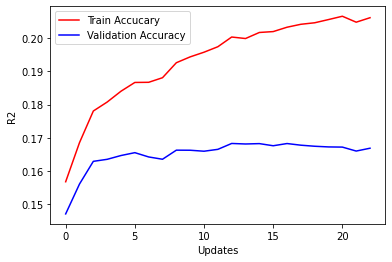

In [49]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

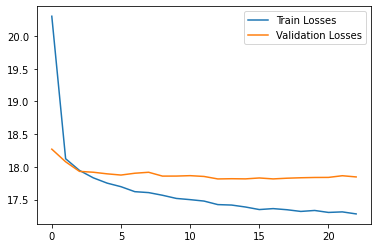

0.17490657143819743


In [50]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

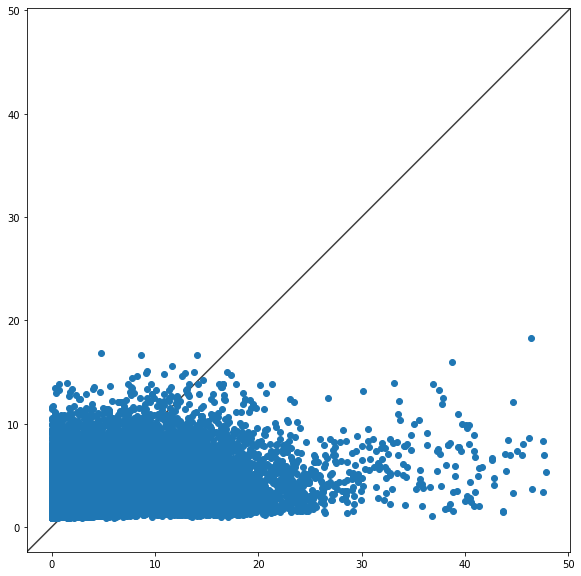

In [51]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With both

In [52]:
df = df_full.drop(columns=weather_var, inplace = False)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [53]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [54]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            #nn.Linear(128,64),
            #nn.ReLU(),#nn.BatchNorm1d(64)),
            #nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18401


In [55]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.850465 , Valid Loss 17.687947 ,Train R2 0.156290, Valid R2 0.157788
Epoch 11: Train Loss 16.887851 , Valid Loss 16.563230 ,Train R2 0.226715, Valid R2 0.211342
Epoch 21: Train Loss 16.588014 , Valid Loss 16.517943 ,Train R2 0.238410, Valid R2 0.213498
Epoch 31: Train Loss 16.417637 , Valid Loss 16.459160 ,Train R2 0.248351, Valid R2 0.216297
Epoch 41: Train Loss 16.247498 , Valid Loss 16.400205 ,Train R2 0.256780, Valid R2 0.219104
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 51: Train Loss 16.108005 , Valid Loss 16.418870 , Train R2 0.261080, Valid R2 0.218216


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

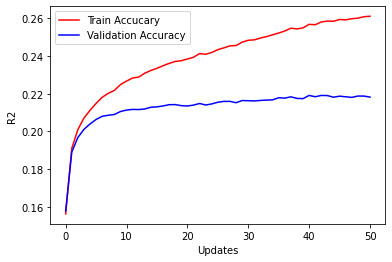

In [56]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

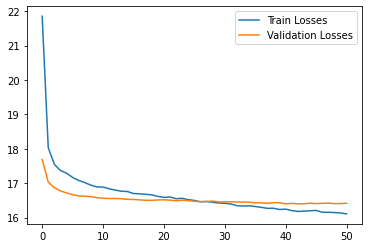

0.2124340119364171


In [57]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

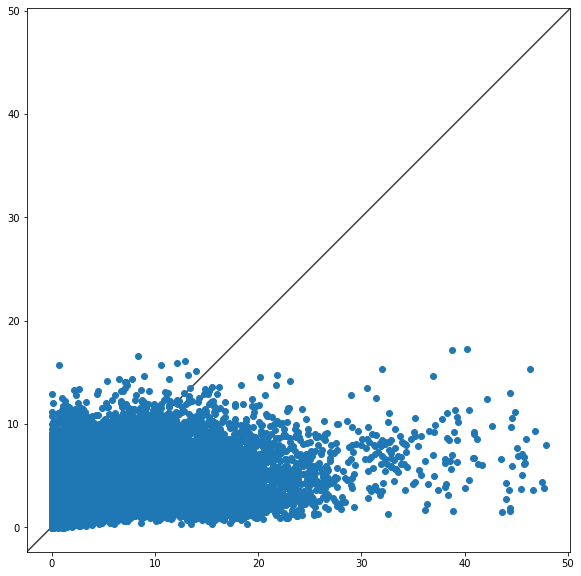

In [58]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather

In [64]:
df = df_full.drop(df.filter(regex='Avg').columns,axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [65]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [66]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60417


In [67]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 17.479329 , Valid Loss 17.696473 ,Train R2 0.175730, Valid R2 0.170171
Epoch 11: Train Loss 16.167773 , Valid Loss 16.905153 ,Train R2 0.237579, Valid R2 0.207278
Epoch 21: Train Loss 15.718551 , Valid Loss 16.840737 ,Train R2 0.258763, Valid R2 0.210299
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 15.494204 , Valid Loss 16.859993 ,Train R2 0.269343, Valid R2 0.209396
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 35: Train Loss 15.476172 , Valid Loss 16.885775 , Train R2 0.270193, Valid R2 0.208187


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

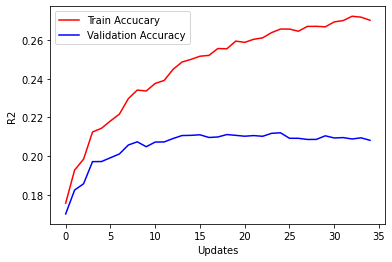

In [68]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

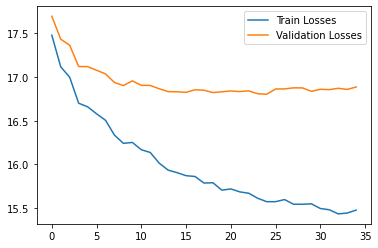

0.21396462238316927


In [69]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

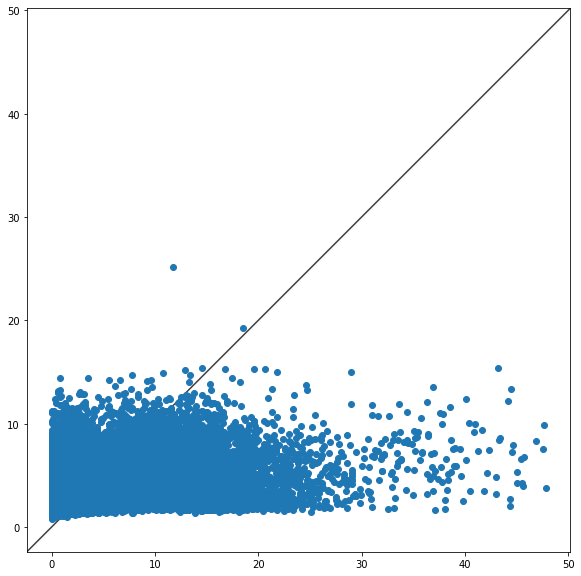

In [70]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Average weather (cheat)

In [71]:
df = df_full.drop(weather_var[:7]+weather_var[-7:],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [72]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [73]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.33),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.33, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.33, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 112385


In [74]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 16.702423 , Valid Loss 16.937632 ,Train R2 0.212057, Valid R2 0.205249
Epoch 11: Train Loss 9.900439 , Valid Loss 11.726977 ,Train R2 0.532943, Valid R2 0.449744
Epoch 21: Train Loss 8.640395 , Valid Loss 11.251903 ,Train R2 0.592386, Valid R2 0.472036
Epoch 31: Train Loss 7.870707 , Valid Loss 10.876395 ,Train R2 0.628696, Valid R2 0.489656
Epoch 41: Train Loss 6.802384 , Valid Loss 10.145603 ,Train R2 0.679095, Valid R2 0.523946
Epoch 51: Train Loss 6.351052 , Valid Loss 9.829231 ,Train R2 0.700387, Valid R2 0.538791
Epoch 61: Train Loss 5.820251 , Valid Loss 9.414220 ,Train R2 0.725427, Valid R2 0.558264
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 5.481455 , Valid Loss 9.286057 ,Train R2 0.741410, Valid R2 0.564278
Epoch 81: Train Loss 5.246126 , Valid Loss 9.061530 ,Train R2 0.752512, Valid R2 0.574813
Epoch 91: Train Loss 5.113322 , Valid Loss 8.823413 ,Train R2 0.758777, Valid R2 0.585986
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

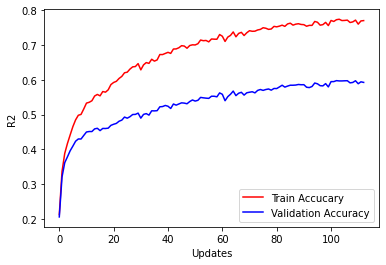

In [75]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

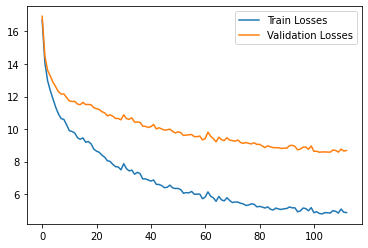

0.5943221204672577


In [76]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

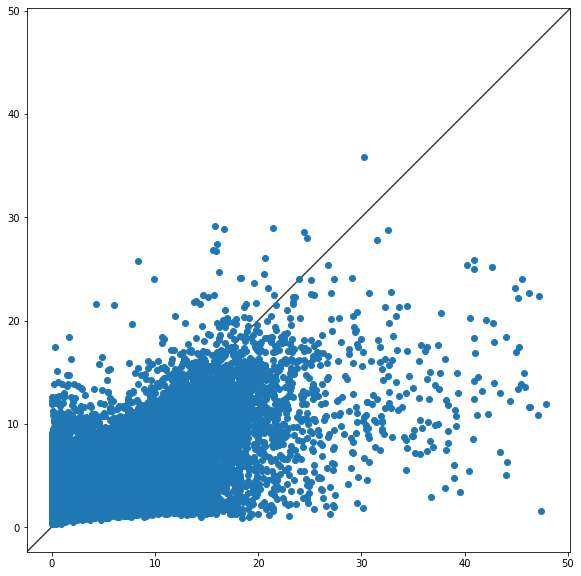

In [77]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Only average weather

In [78]:
df_w = df_full[weather_var[7:14]+['dist_to_station']]
df_w

,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...
326587,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [79]:
train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [80]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.25),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 43521


In [81]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.397242 , Valid Loss 18.246468 ,Train R2 0.137937, Valid R2 0.139902
Epoch 11: Train Loss 10.002106 , Valid Loss 10.319189 ,Train R2 0.531319, Valid R2 0.513576
Epoch 21: Train Loss 7.896137 , Valid Loss 8.384021 ,Train R2 0.630001, Valid R2 0.604796
Epoch 31: Train Loss 6.884313 , Valid Loss 7.403332 ,Train R2 0.677413, Valid R2 0.651023
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 6.363778 , Valid Loss 6.942247 ,Train R2 0.701804, Valid R2 0.672758
Epoch 51: Train Loss 6.032946 , Valid Loss 6.720377 ,Train R2 0.717307, Valid R2 0.683216
Epoch 61: Train Loss 5.693377 , Valid Loss 6.354662 ,Train R2 0.733218, Valid R2 0.700455
Epoch 71: Train Loss 5.290922 , Valid Loss 5.946507 ,Train R2 0.752077, Valid R2 0.719695
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 5.378355 , Valid Loss 6.031057 ,Train R2 0.747980, Valid R2 0.715709
Epoch 91: Train Loss 5.016286 , Valid Loss 5.703407 ,Train R2 0.764946, Valid R2 0.731154
EarlyStopping counter: 5 o

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

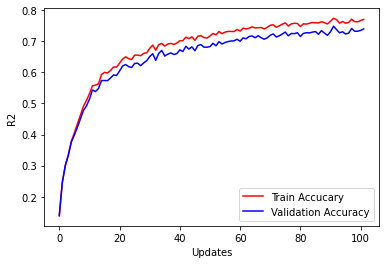

In [82]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

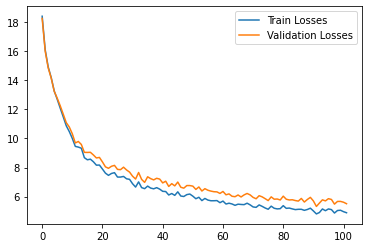

0.745012578362626


In [83]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

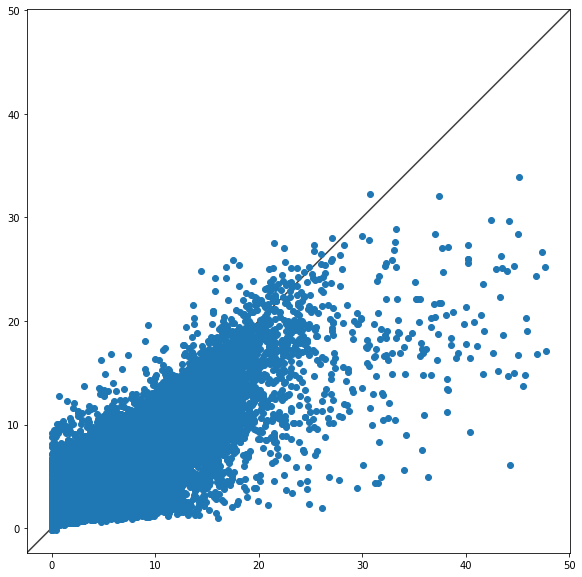

In [84]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather (index)

In [85]:
df = df_full.drop(weather_var[:14],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805


In [86]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [87]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26177


In [88]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0004) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.038641 , Valid Loss 17.824465 ,Train R2 0.154420, Valid R2 0.152522
Epoch 11: Train Loss 16.399092 , Valid Loss 16.686431 ,Train R2 0.231275, Valid R2 0.206631
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 16.082939 , Valid Loss 16.580909 ,Train R2 0.246095, Valid R2 0.211648
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 25: Train Loss 16.018229 , Valid Loss 16.638494 , Train R2 0.249129, Valid R2 0.208910


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

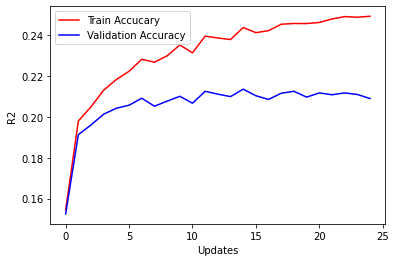

In [89]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

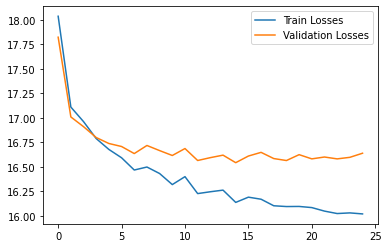

0.21063683400314692


In [90]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

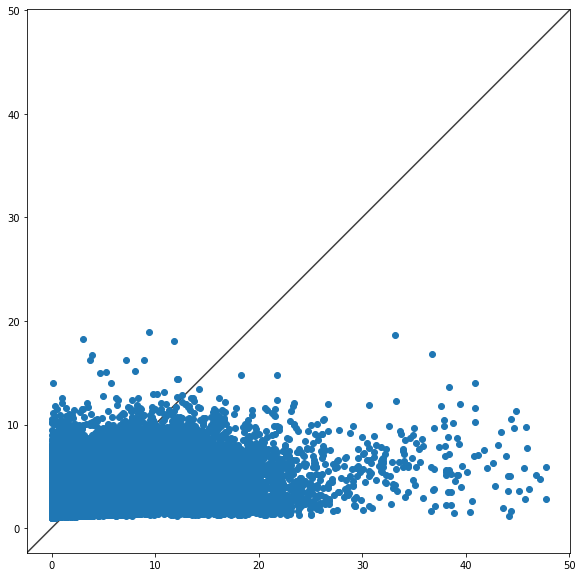

In [91]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With average weather and embedding

In [98]:
df = df_full.drop(weather_var[:14],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df = df.drop(columns = ['index', 'Time_Cos', 'Time_Sin'])
df

,leave_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,6.618094,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080,209
1,86,14.027280,0,6.618094,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483,138
2,4,17.751882,0,6.618094,1,0,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,6.618094,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806,235
4,32,13.214864,0,6.618094,0,1,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.318741,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500,63
326588,59,14.221806,0,6.318741,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658,45
326589,48,16.451925,0,6.318741,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913,75
326590,23,15.140361,0,6.318741,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805,148


In [99]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [100]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(16+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30121


In [101]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.460076 , Valid Loss 18.578130 ,Train R2 0.133693, Valid R2 0.131821
Epoch 11: Train Loss 16.188680 , Valid Loss 16.535247 ,Train R2 0.240286, Valid R2 0.227287
Epoch 21: Train Loss 15.754503 , Valid Loss 16.391687 ,Train R2 0.260662, Valid R2 0.233996
Epoch 31: Train Loss 15.403743 , Valid Loss 16.286514 ,Train R2 0.277122, Valid R2 0.238911
Epoch 41: Train Loss 15.148851 , Valid Loss 16.292442 ,Train R2 0.289084, Valid R2 0.238634
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 50: Train Loss 14.978260 , Valid Loss 16.309393 , Train R2 0.297090, Valid R2 0.237842


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

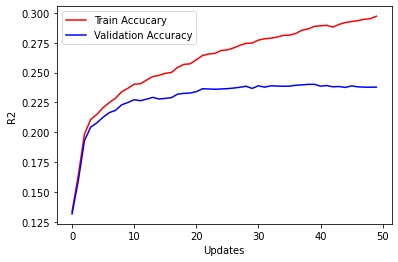

In [102]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

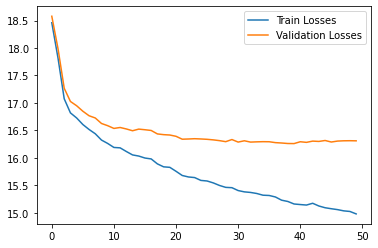

0.23599874323096515


In [103]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

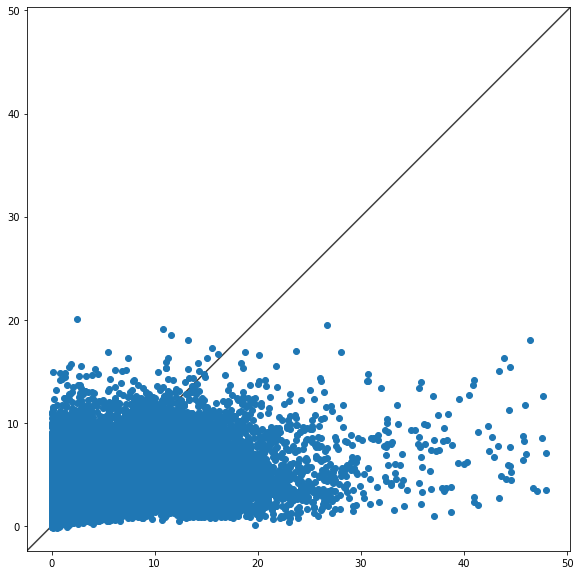

In [104]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

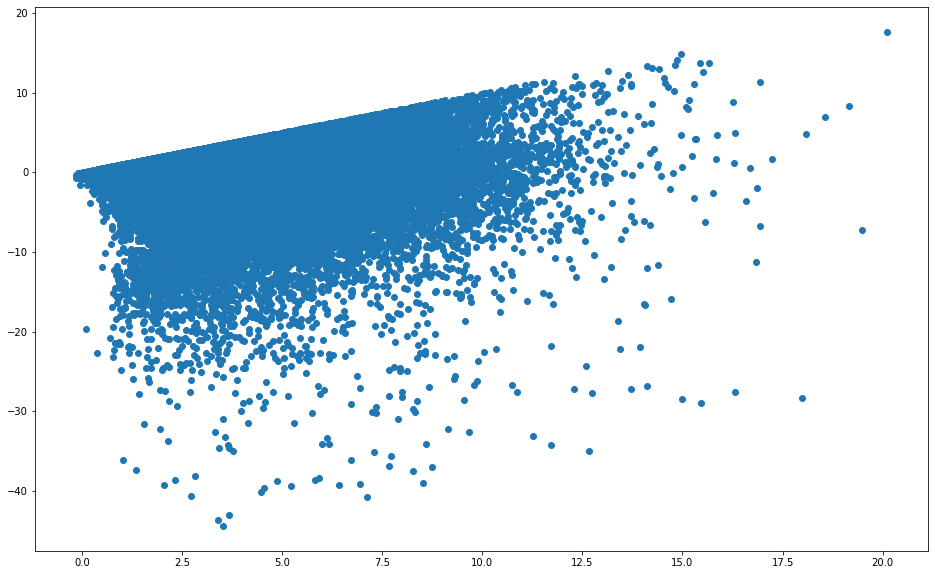

In [106]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])
plt.show()

In [107]:
np.corrcoef(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

array([[1.       , 0.0291813],
       [0.0291813, 1.       ]])

In [109]:
np.mean(net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

0.04562777

## Embedding and cheating with weather

In [99]:
df = df_full.drop(weather_var[:7]+weather_var[-7:],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station,Zone
0,43,12.529378,0,6.805269,0,0,1,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080,209
1,86,14.027280,0,6.805269,0,0,1,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483,138
2,5,17.751882,0,6.805269,1,0,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,6.805269,0,0,1,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806,235
4,32,13.214864,0,6.805269,0,1,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500,63
326588,57,14.221806,0,6.457874,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658,45
326589,48,16.451925,0,6.457874,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913,75
326590,23,15.140361,0,6.457874,0,0,1,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805,148


In [100]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [101]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(16+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30121


In [102]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.206798 , Valid Loss 17.947690 ,Train R2 0.151003, Valid R2 0.151010
Epoch 11: Train Loss 10.221440 , Valid Loss 10.599374 ,Train R2 0.523366, Valid R2 0.498612
Epoch 21: Train Loss 7.771086 , Valid Loss 8.374417 ,Train R2 0.637628, Valid R2 0.603860
Epoch 31: Train Loss 6.597643 , Valid Loss 7.310964 ,Train R2 0.692347, Valid R2 0.654165
Epoch 41: Train Loss 5.997927 , Valid Loss 6.760843 ,Train R2 0.720312, Valid R2 0.680188
Epoch 51: Train Loss 5.544930 , Valid Loss 6.359917 ,Train R2 0.741436, Valid R2 0.699153
Epoch 61: Train Loss 5.205110 , Valid Loss 6.040889 ,Train R2 0.757282, Valid R2 0.714244
Epoch 71: Train Loss 4.974799 , Valid Loss 5.851832 ,Train R2 0.768021, Valid R2 0.723187
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 5.006804 , Valid Loss 5.828625 ,Train R2 0.766529, Valid R2 0.724285
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 90: Train Loss 4.769545 , Valid Loss 5.595011 , Train R2 0.

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

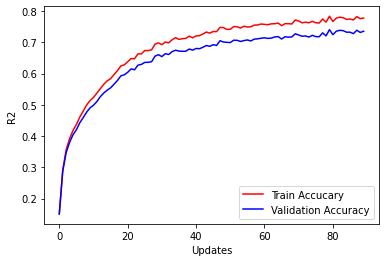

In [103]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

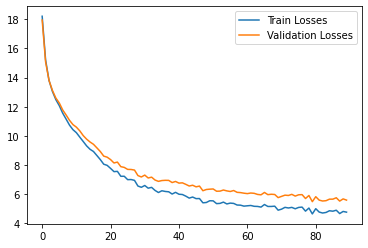

0.7241027006509031


In [104]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

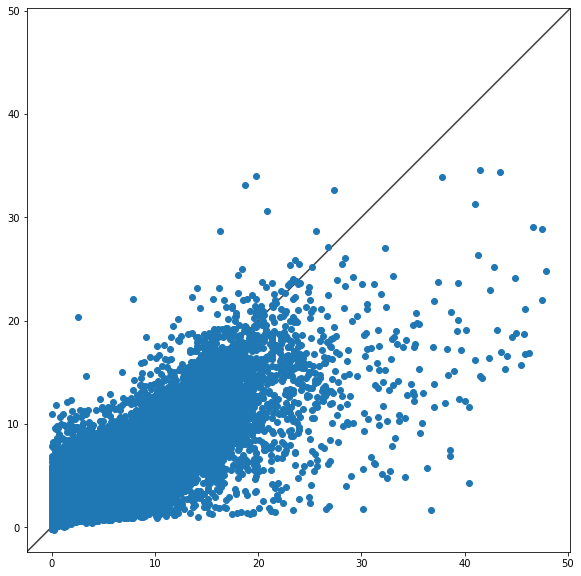

In [105]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()